In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE 
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

from nfmd.NFMD import NFMD
from utils import get_noise

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
# Experimental data examples
taus = ["100e-9", "250e-9", "500e-9",  "1e-6", "5e-6", "10e-6", "100e-6", "1e-3"]

# Load in file to extract shape data
file_stem = "./Experimental/tau_"
fn = file_stem + str(taus[0]) + ".npy"
z_all = np.load(fn)

# Define a time vector:
fs = 10e6
n = z_all.shape[0]
t = np.linspace(0, n/fs, n)
dt = t[1]-t[0]

In [3]:
%%time
#####################
##  Analyze by FMD ##
#####################

# Set Fourier fit method parameters
window_size = 39
half_window = int(window_size/2)

# Initialize results dictionary, indexed by tau value
results = {}

for tau in taus:
    print(tau, end=" | ")
    
    # Load in file and average trials
    fn = file_stem + str(tau) + ".npy"
    z = np.load(fn)
    
    # Fourier window sliding methods
    # Apply NFMD method:
    nfmd = NFMD(z.copy()/np.std(z)+1,
                num_freqs=2,
                window_size=window_size,
                optimizer_opts={'lr': 1e-04},
                max_iters=500,
                target_loss=1e-4)
    
    freqs, A, losses, indices = nfmd.decompose_signal()
    
    # Compute corrected results, and save them:
    n_freqs = nfmd.correct_frequencies(dt=dt)
    n_amps = nfmd.compute_amps()
    n_mean = nfmd.compute_mean()
    
    results[tau] = n_freqs, n_amps, n_mean, freqs, A, losses, indices


100e-9 | 250e-9 | 500e-9 | 1e-6 | 5e-6 | 10e-6 | 100e-6 | 1e-3 | Wall time: 1min 50s


In [4]:
# Pull out the means, subtracting the '1' that was added to the signal
# Note: the added 1 to the signal improves detection of the mean, which otherwise may be considered 
# noise by the algorithm
means = [(1-results[tau][2])*np.std(z) for tau in taus]
# Then, ensure it is on a zero baseline:
means = [mean-np.mean(mean[:1000]) for mean in means]
nfmd_ts = t[nfmd.mid_idcs]

In [5]:
%%time

# Constants for models with constants
tp = 0.001638
decay_lambda = 1080.80


# 4 DoF
model5 = lambda p, t: np.heaviside(t-p[2],0.5)*p[0]*np.exp(-p[3]*(t-p[2]))*np.expm1(-(t-p[2])/p[1]) # Target function
p0_5 = [1, 5e-6, 0.001636, 1080] # Initial guess for the parameters

# 3 DoF (lambda=0)
model4 = lambda p, t: np.heaviside(t-tp,0.5)*p[0]*np.expm1(-(t-tp)/p[1]) # Target function
p0_4 = [1, 5e-6, 0.001636] # Initial guess for the parameters

# 2 DoF (fixed t_perturb and lambda decay)
model3 = lambda p, t: np.heaviside(t-tp,0.5)*p[0]*np.exp(-decay_lambda*(t-tp))*np.expm1(-(t-tp)/p[1]) # Target function
p0_3 = [1, 5e-6] # Initial guess for the parameters

# 3 DoF (fixed decay constant)
model2 = lambda p, t: np.heaviside(t-p[2],0.5)*p[0]*np.exp(-decay_lambda*(t-p[2]))*np.expm1(-(t-p[2])/p[1]) # Target function
p0_2 = [1, 5e-6, 0.001636] # Initial guess for the parameters

# 3 DoF (fixed tp)
model1 = lambda p, t: np.heaviside(t-tp,0.5)*p[0]*np.exp(-p[2]*(t-tp))*np.expm1(-(t-tp)/p[1]) # Target function
p0_1 = [1, 1e-6, 1080] # Initial guess for the parameters

# Error function to minimize
errfunc = lambda p, x, y, model: model(p, x) - y # Distance to the target function

# List of predicted tau values:
predicted_taus = []

# Find an optimized fit for each model:
for mean, tau in zip(means, taus):
    # Fit each of the prospective models
    p1, success = optimize.leastsq(errfunc, p0_1[:], args=(nfmd_ts, mean, model1))
    p2, success = optimize.leastsq(errfunc, p0_2[:], args=(nfmd_ts, mean, model2))
    p3, success = optimize.leastsq(errfunc, p0_3[:], args=(nfmd_ts, mean, model3))
    p4, success = optimize.leastsq(errfunc, p0_4[:], args=(nfmd_ts, mean, model4))
    p5, success = optimize.leastsq(errfunc, p0_5[:], args=(nfmd_ts, mean, model5))
    # Estimate the time constant for the expm1
    predicted_taus.append([ p5[1], p1[1], p2[1], p3[1], p4[1] ])


Wall time: 7.34 s


In [6]:
true_taus = np.asarray([float(tau) for tau in taus])
pt = np.asarray(predicted_taus)

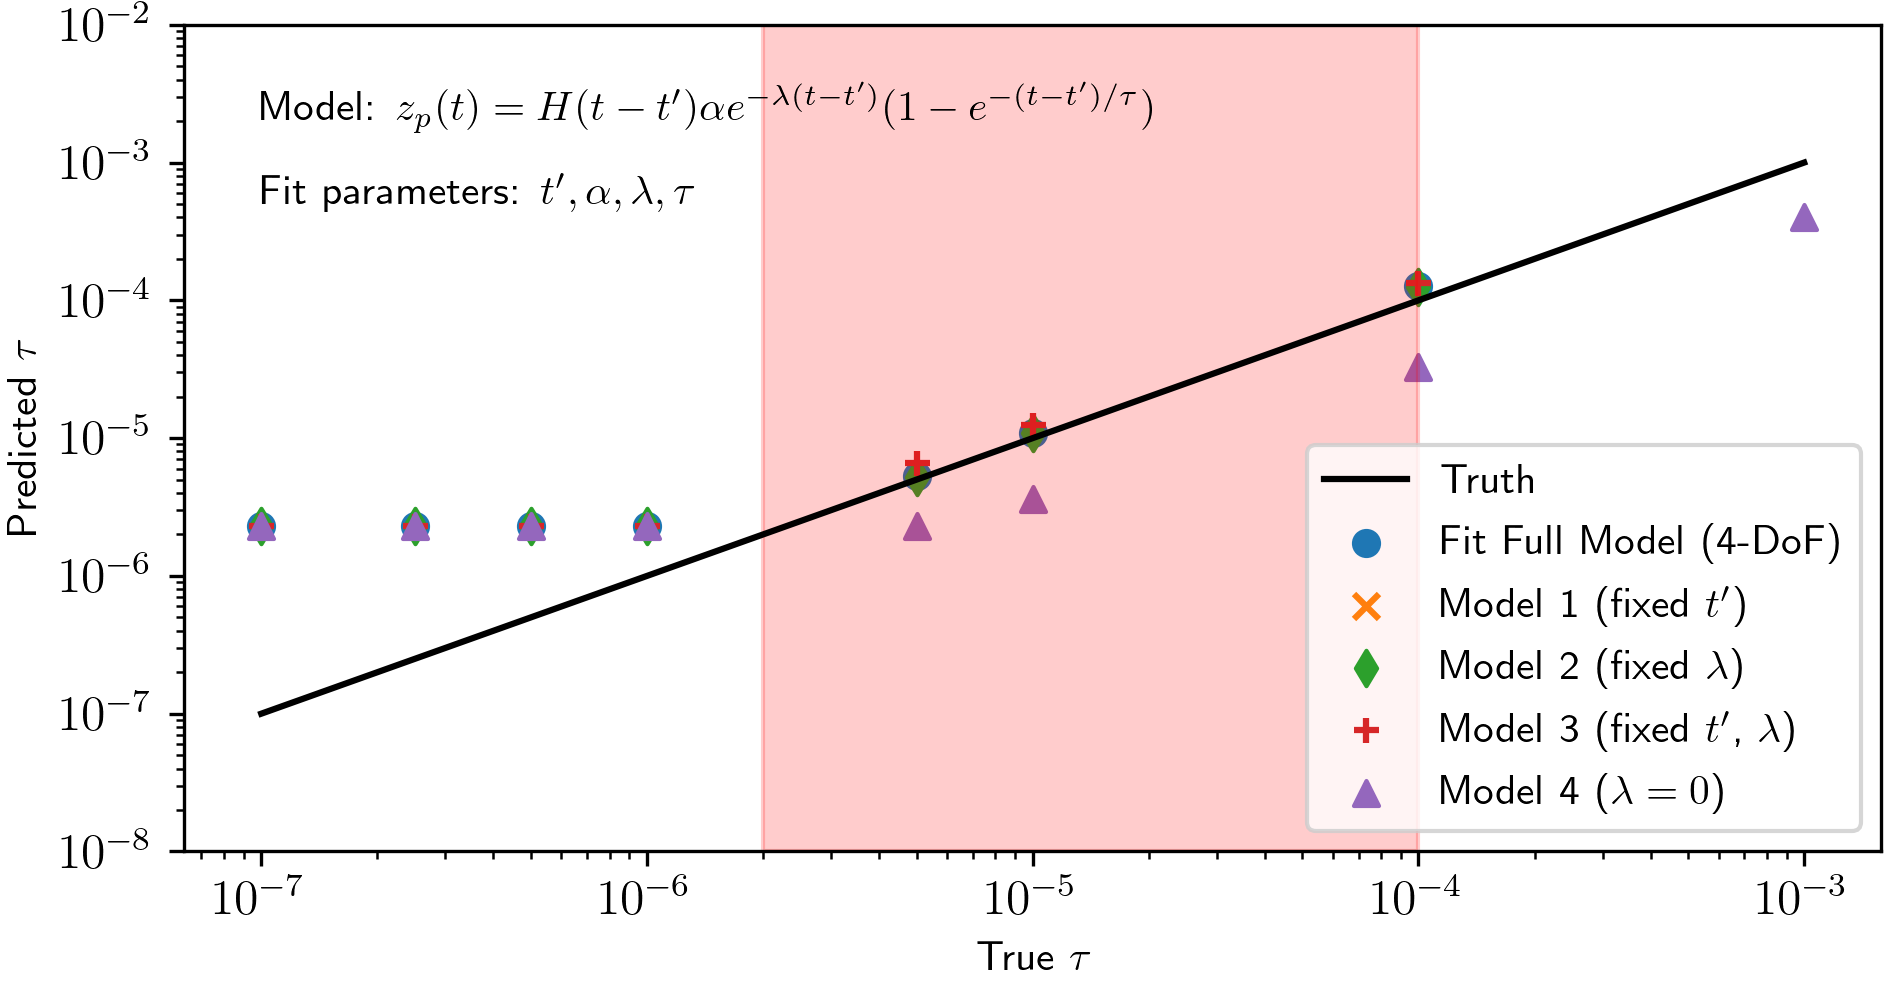

In [7]:
markers = ['o', 'x', 'd', '+', '^']
for i in range(pt.shape[-1]):
    plt.scatter(true_taus, pt[:,i], marker=markers[i])
#l1 = plt.loglog(true_taus, , 'x', label=r'Predicted $\tau$', alpha=0.5)
plt.loglog(true_taus, true_taus, '-k')
plt.xlabel(r"True $\tau$")
plt.ylabel(r"Predicted $\tau$")
plt.legend(["Truth",
            r"Fit Full Model (4-DoF)",
            r"Model 1 (fixed $t'$)",
            r"Model 2 (fixed $\lambda$)",
            r"Model 3 (fixed $t'$, $\lambda$)",
            r"Model 4 ($\lambda=0$)",
            ], 
           loc='lower right')
model_text=r"Model: $z_p(t)=H(t-t') \alpha e^{-\lambda (t-t')} (1-e^{-(t-t')/\tau})$"
param_text=r"Fit parameters: $t', \alpha, \lambda, \tau$"
plt.text(1e-7,2e-3,model_text)
plt.text(1e-7,5e-4,param_text)
plt.ylim([1e-8,1e-2])
plt.axvspan(2e-6,1e-4,color='red',alpha=0.2)
plt.show()

[-4.53310381e-03  2.30364476e-06  1.63691740e-03  1.07882226e+03] 1e-07
[-4.53672447e-03  2.30368917e-06  1.63700061e-03  1.08250862e+03] 2.5e-07
[-4.51062683e-03  2.30431462e-06  1.63738509e-03  1.07875359e+03] 5e-07
[-4.48488673e-03  2.30499406e-06  1.63794054e-03  1.07980312e+03] 1e-06
[-4.45766696e-03  5.33346738e-06  1.63938070e-03  1.09312246e+03] 5e-06
[-4.48340204e-03  1.09399893e-05  1.63956983e-03  1.07991685e+03] 1e-05
[-5.06855897e-03  1.26271496e-04  1.64422108e-03  1.08484959e+03] 0.0001
[-2.93836959e+00  8.38019282e-01  1.66993381e-03  8.97290340e+02] 0.001


(0.0016359, 0.0016460000000000001)

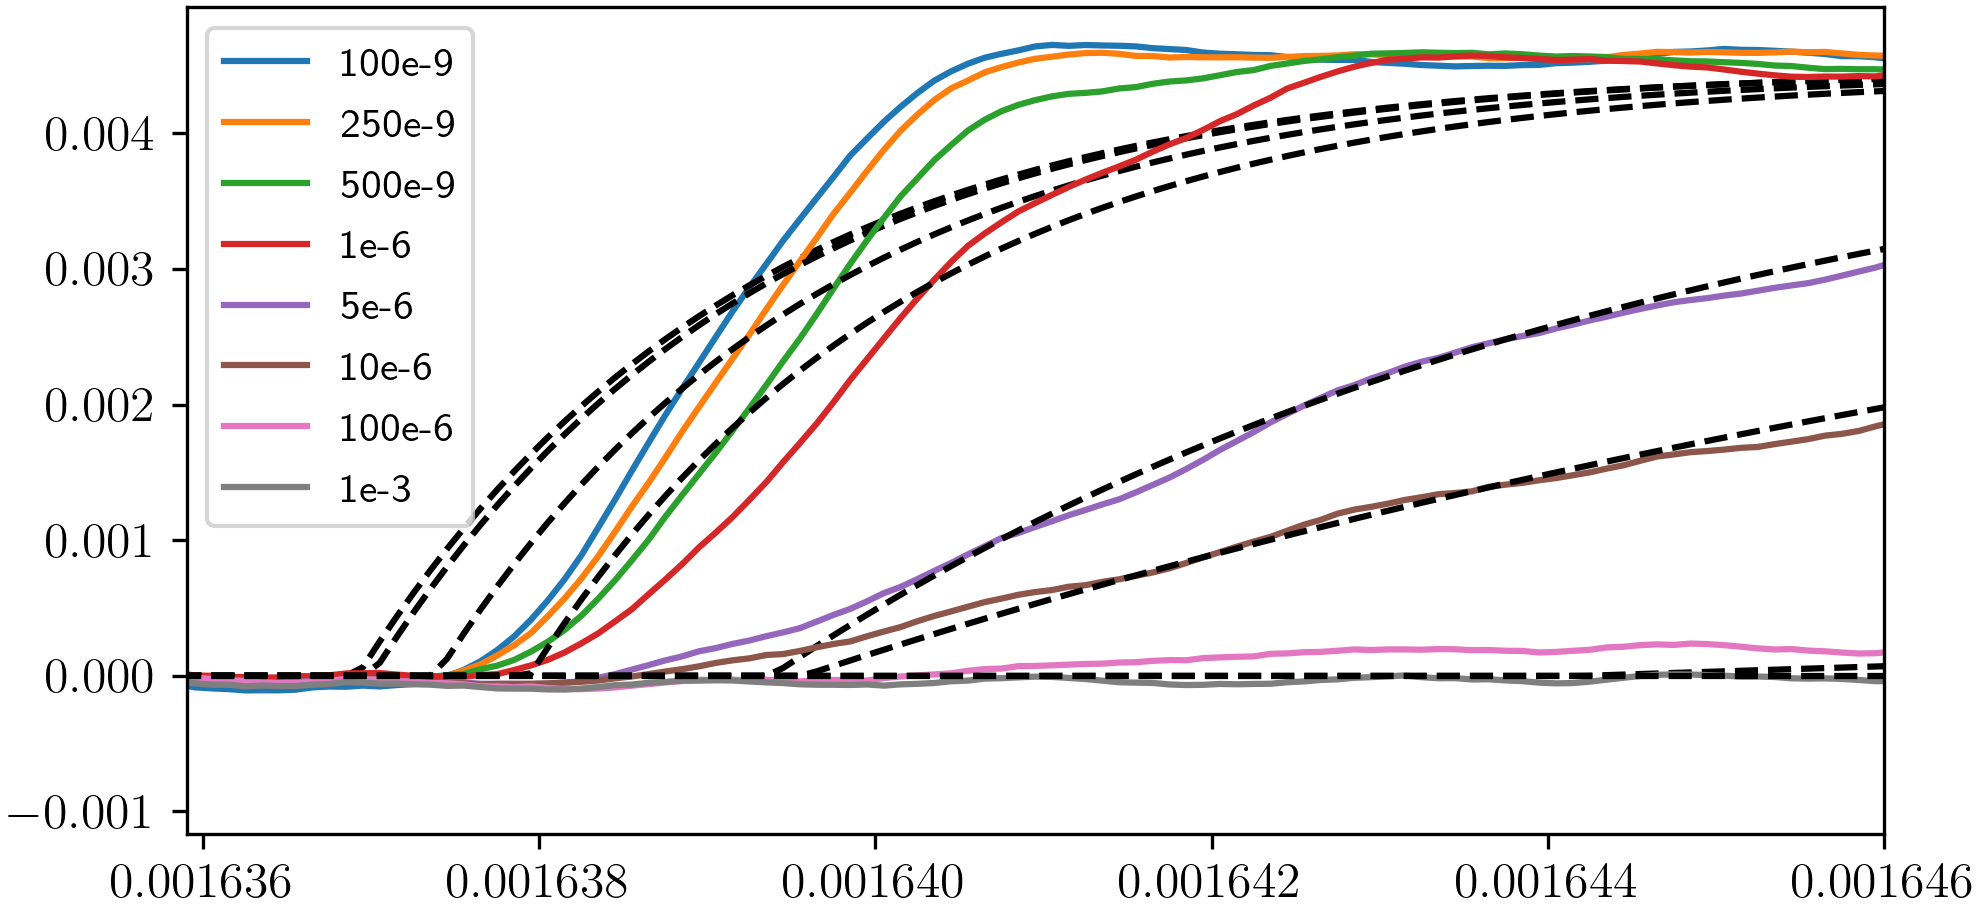

In [8]:
# Constants for models with constants
tp = 0.001636
decay_lambda = 1080.80

# 4 DoF
model5 = lambda p, t: np.heaviside(t-p[2],0.5)*p[0]*np.exp(-p[3]*(t-p[2]))*np.expm1(-(t-p[2])/p[1]) # Target function
p0_5 = [1, 5e-6, 0.001636, 1080] # Initial guess for the parameters

# Error function to minimize
errfunc = lambda p, x, y, model: model(p, x) - y # Distance to the target function

predictions = []


for mean, tau in zip(means, taus):
    plt.plot(nfmd_ts, mean, label=tau)
    
    p1, success = optimize.leastsq(errfunc, p0_5[:], args=(nfmd_ts, mean, model5))
    prediction = model5(p1,t)
    plt.plot(t, model5(p1,t), '--k')
    predictions.append(prediction)
    print(p1, float(tau))
    
    
plt.legend()
plt.xlim(tp-1e-7,tp+1e-5)

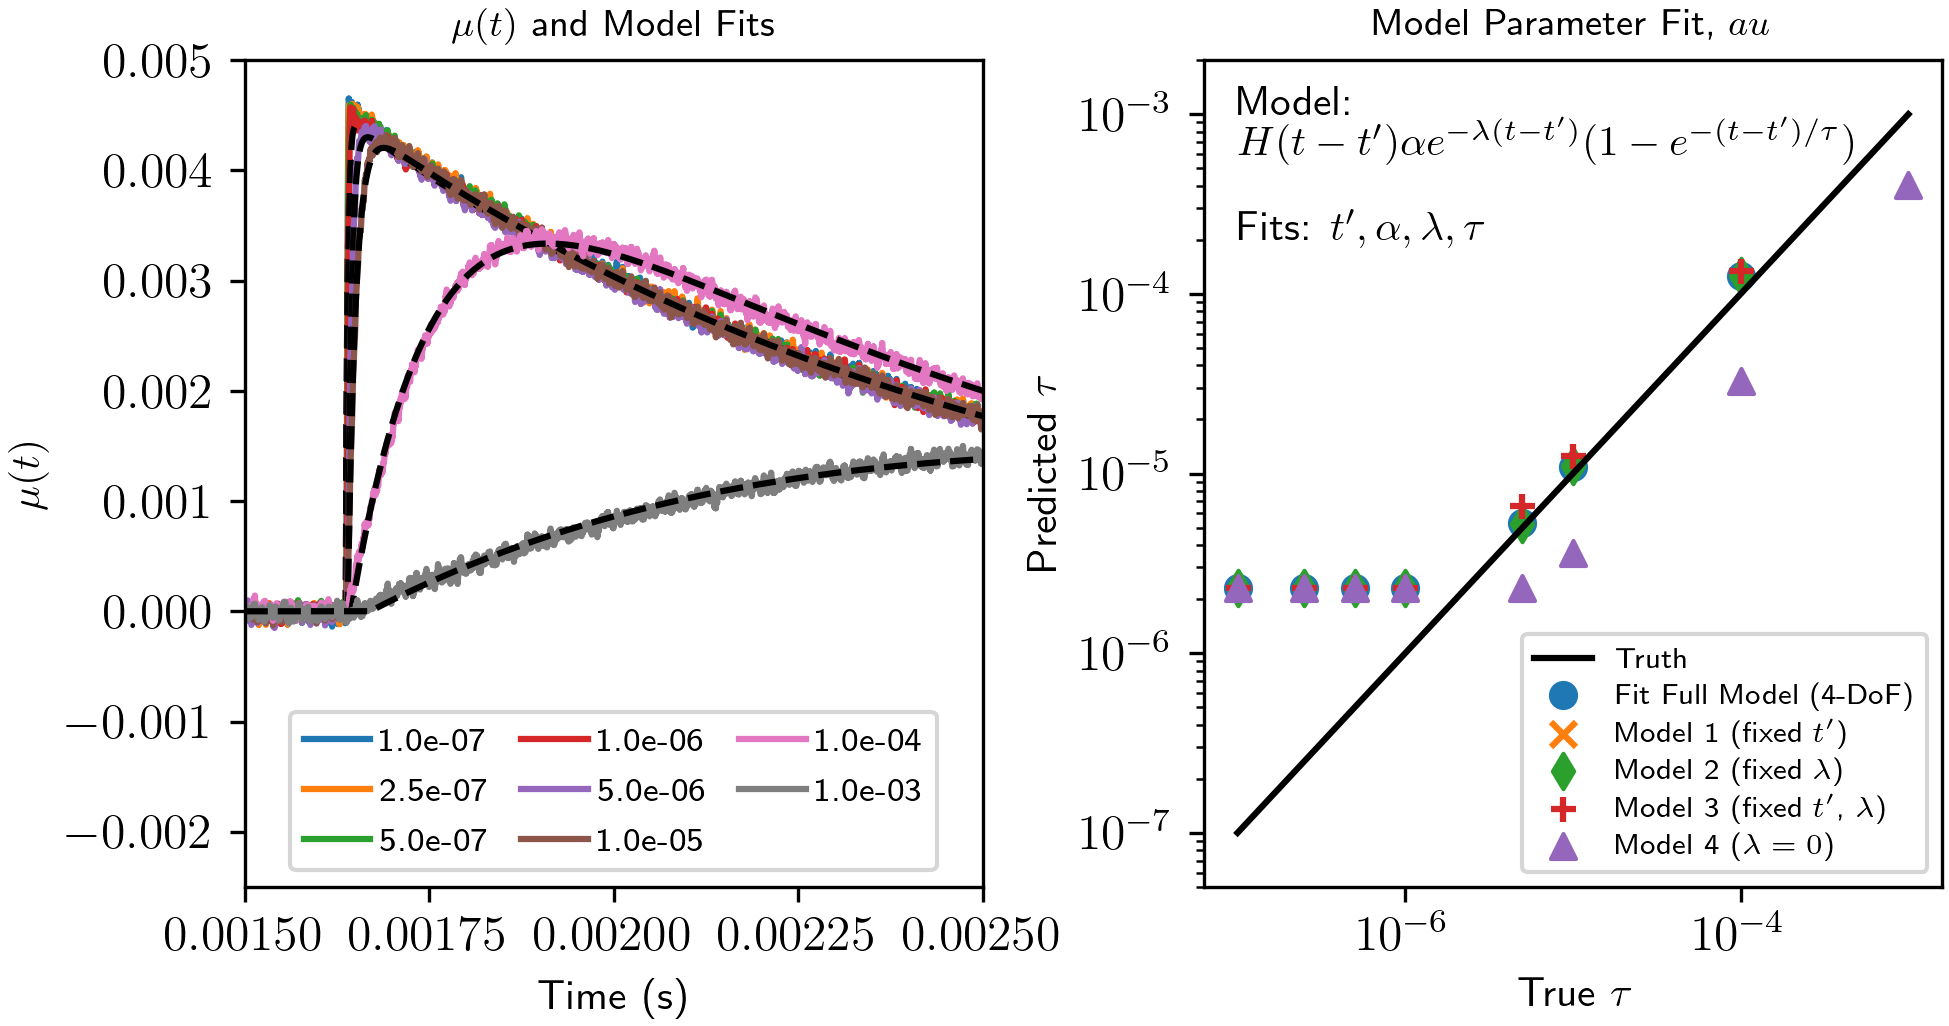

In [9]:
fig3 = plt.figure()
gs = fig3.add_gridspec(1, 2)

##############################
## Top Row -- Driving Force ##
##############################
ax1 = fig3.add_subplot(gs[0, 0])

for mean, prediction, tau in zip(means, predictions, taus):
    label = "{:.1e}".format(float(tau))
    ax1.plot(nfmd_ts, mean, label=label)
    ax1.plot(t, prediction, '--k')



ax2 = fig3.add_subplot(gs[0, 1])

markers = ['o', 'x', 'd', '+', '^']
for i in range(pt.shape[-1]):
    plt.scatter(true_taus, pt[:,i], marker=markers[i])
ax2.loglog(true_taus, true_taus, '-k')



# Put titles on the 3a and 3b columns
ax1.set_title('$\mu(t)$ and Model Fits', fontsize=9)
ax2.set_title('Model Parameter Fit, $\tau$', fontsize=9)

################
## Formatting ##
################
# Left axes
ax1.set_xlim(1.5e-3,2.5e-3)
ax1.set_ylim([-2.5e-3,5e-3])
ax1.set_ylabel("$\mu(t)$")
ax1.set_xlabel("Time (s)")


ax1.legend(loc="lower center", ncol=3, handletextpad=0.3, columnspacing=1.0, fontsize=8)

# Right axes
ax2.set_xlabel(r"True $\tau$")
ax2.set_ylabel(r"Predicted $\tau$")
ax2.legend(["Truth",
            r"Fit Full Model (4-DoF)",
            r"Model 1 (fixed $t'$)",
            r"Model 2 (fixed $\lambda$)",
            r"Model 3 (fixed $t'$, $\lambda$)",
            r"Model 4 ($\lambda=0$)",
            ] 
           , loc='lower right' 
           , fontsize=7
           , labelspacing=0.25)

ax2.set_ylim([5e-8,2e-3])

model_text=r"$H(t-t') \alpha e^{-\lambda (t-t')} (1-e^{-(t-t')/\tau})$"
param_text=r"Fits: $t', \alpha, \lambda, \tau$"
ax2.text(1e-7,1e-3, "Model:")
ax2.text(1e-7,6e-4,model_text)
ax2.text(1e-7,2e-4,param_text)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.savefig("shea12.png")

plt.show()